In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
from torch.utils.data import Dataset, DataLoader
#import data_layer_cross 
import statistics
import seaborn as sns

In [2]:
class NeuralNet(nn.Module):
    """
    Neural network meta model
    """

    def __init__(self, input_dim, intermediate_dims=(20, 40, 20), dropout=0.9):

        super(NeuralNet, self).__init__()
        self.input_dim = input_dim
        self.intermediate_dims = intermediate_dims
        # define the number of hidden layers
        self.hidden_num = len(intermediate_dims) + 1
        self.dropout = dropout
        self.output_dim = 1

        # define the first hidden layer
        exec("self.hidden_layer1 = nn.Linear({}, {})".format(input_dim, intermediate_dims[0]))
        # define the following hidden layers except for the last layer
        for i in range(len(intermediate_dims) - 1):
            exec(
                "self.hidden_layer{} = nn.Linear({}, {})".format(i + 2, intermediate_dims[i], intermediate_dims[i + 1]))
        # define the last hidden layer
        exec("self.hidden_layer_last = nn.Linear({}, 1)".format(intermediate_dims[-1]))

    def forward(self, x):
        # use loop to determine the next hidden layers
        for i in range(self.hidden_num - 1):
            x = eval("self.hidden_layer{}(x)".format(1 + i))
            x = F.relu(x)
            x = nn.functional.dropout(x, p=self.dropout)

        y = self.hidden_layer_last(x)
        y = torch.tanh(y)


        return y

    def __repr__(self):
        return "NeuralNet(input_dim={}, output_dim={}, intermediate_dims={}, dropout={})".format(
            self.input_dim.__repr__(), self.output_dim.__repr__(),
            self.intermediate_dims.__repr__(), self.dropout.__repr__()
        )

In [3]:
#read input data 
datapath = "Data and Code for Machine-Learning the Skill of Mutual Fund Managers/deep_learning/datasets/CharAll_na_rm_huge_train_variableall4_sentiment_full_new.npz"
data = np.load(datapath)
data, data['data'].shape, data['variable']

(NpzFile 'Data and Code for Machine-Learning the Skill of Mutual Fund Managers/deep_learning/datasets/CharAll_na_rm_huge_train_variableall4_sentiment_full_new.npz' with keys: date, variable, wficn, data,
 (469, 3271, 61),
 array(['FC2Y', 'Beta', 'OA', 'CF', 'Variance', 'BEME', 'CTO', 'RNA', 'NI',
        'r12_2', 'CF2P', 'r36_13', 'ROA', 'r2_1', 'Resid_Var', 'DPI2A',
        'IdioVol', 'AC', 'PM', 'ATO', 'D2A', 'SUV', 'SGA2S', 'r12_7',
        'PCM', 'LT_Rev', 'D2P', 'Rel2High', 'LTurnover', 'ROE', 'MktBeta',
        'Investment', 'Lev', 'LME', 'E2P', 'ST_Rev', 'Spread', 'Q', 'A2ME',
        'NOA', 'C', 'OP', 'S2P', 'OL', 'AT', 'PROF', 'ages', 'flow',
        'exp_ratio', 'tna', 'turnover', 'Family_TNA', 'fund_no',
        'Family_r12_2', 'Family_flow', 'Family_age', 'F_ST_Rev', 'F_r2_1',
        'F_r12_2', 'sentiment'], dtype='<U12'))

In [4]:
data['data'][-1,:,0]

array([ 6.10662885e-03,  8.87223848e-03, -9.99900000e+01, ...,
        1.14191483e-03, -4.77147598e-03,  1.50781037e-02])

In [5]:
with open('data.txt','w') as file:
    for item in data['data'][-1, :, :]: #(time, funds, variables)
        file.write(f"{item}\n")
    
file.close()

In [6]:
#part3.1: sampling schemes 
def chronological_sampling_scheme(total_time_periods, split_ratio):
    """
    Simulates the chronological sampling scheme.
    total_time_periods(int):The total number of time periods(469)
    split_ratio (list or array of float): The split ratio [train, val, test]
    """
    split_ratio = np.array(split_ratio)
    if sum(split_ratio) != 1:#normalize
        split_ratio = split_ratio / sum(split_ratio)
    train_size = int(total_time_periods * split_ratio[0])
    val_size = int(total_time_periods * split_ratio[1])
    test_size = total_time_periods - train_size - val_size
    #get indices 
    test_indices = np.arange(0, test_size)
    val_indices = np.arange(test_size, test_size + val_size)
    train_indices = np.arange(test_size + val_size, total_time_periods)
    return (test_indices, val_indices, train_indices)
def random_sampling_scheme(total_time_periods, split_ratio, random_seed=None):
    """The random sampling scheme"""
    split_ratio = np.array(split_ratio)
    if sum(split_ratio) != 1:#normalize
        split_ratio = split_ratio / sum(split_ratio)
    train_size = int(total_time_periods * split_ratio[0])
    val_size = int(total_time_periods * split_ratio[1])
    test_size = total_time_periods - train_size - val_size
    #randomize all indices
    all_indices = np.arange(total_time_periods)
    if random_seed is not None:
        np.random.seed(random_seed)
    np.random.shuffle(all_indices)
    test_indices = all_indices[:test_size]
    val_indices = all_indices[test_size:test_size + val_size]
    train_indices = all_indices[test_size + val_size:]
    return (train_indices, val_indices, test_indices)
def split_list_chronological(data, ratio):
    '''given data(list), return two sublists by ratio, chronologically'''
    split_index = int(len(data) * ratio)
    part1 = data[:split_index]
    part2 = data[split_index:]
    return part1, part2

In [7]:
def replace_outliers(array, upper, lower, replace=0):
    # Create a mask for values that are less than lower or greater than upper
    #by default replace with 0 
    mask = (array < lower) | (array > upper)
    array[mask] = replace
    return array

In [8]:
#pytorch dataset to help load input data

class DS(Dataset):
    '''constrcuct datast with input data(the dataset) and index list'''
    def __init__(self, data, idx_list, subset=None):
        #data --> the unprocessed input
        #index list: the selected indexes
        if subset:
            column_considered = [0] + [x + 1 for x in subset] #keep the first column(label)
            self.all_data = data['data'][:, :, column_considered]
        else:
            self.all_data = data['data']
        self.variables = data['variable'] 
        labels = self.all_data[:, :, 0]  #the first column contains the labels 
        labels = np.expand_dims(self.filter_data_by_indices(labels, idx_list),axis=2)
        print("labels shape",labels.shape)
        features = self.all_data[:, :, 1:] #the others are the input features
        features = self.filter_data_by_indices(features, idx_list)
        features = replace_outliers(features, 0.5, -0.5, 0) #replace any missing values with 0 
        print("features shape",features.shape)
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        
    def filter_data_by_indices(self, data, indices):
    #method to filter data with predefined indices
        return data[indices]
    
    def __len__(self):
        return self.features.shape[0] 

    def __getitem__(self, idx):
        #timestep = self.features.shape[0] - idx #during training, go from past time (larger index) to future time (smaller index)
        return self.features[idx], self.labels[idx] #get next month's label

In [9]:
def checkdb(dataset, dataloader):
    sample_features, sample_labels = dataset[0]
    print("Features shape:", sample_features.shape)
    print("Labels shape:", sample_labels.shape)
    data_iter = iter(dataloader)
    batch_features, batch_labels = next(data_iter) 
    print("Batch Features shape:", batch_features.shape)
    print("Batch Labels shape:", batch_labels.shape)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
def loss_with_filter(preds, labels, lower=-1, upper = 1):
    #a custom loss function that filters placeholder values in the labels 
    #use MSE for the rest
    mask = (labels > lower) & (labels < upper)
    #print(preds.shape)
    #print(labels.shape)
    filtered_preds = preds[mask]
    filtered_labels = labels[mask]
    #print(filtered_preds.shape)
    #print(filtered_labels.shape)
    #use mse
    #print(filtered_labels, filtered_preds)
    loss = nn.MSELoss()(filtered_preds, filtered_labels)
    return loss
def loss_with_filter_label_and_features(preds, labels, inputs, upper = 0.5, lower=-0.5):
    #filter both labels and input features
    #skip row if there is a missing value in features 
    global all_invalid_inputs
    #print(inputs.shape)
    mask_inputs = (inputs < upper).all(dim=-1, keepdim=True)
    mask_inputs = mask_inputs & ((inputs > lower).all(dim=-1, keepdim=True))
    mask = mask_inputs & (labels > lower) & (labels < upper)

    #total_funds = mask.shape[1]  
    #valid_rows_per_timestep = mask.sum(dim=1)  
    #all_invalid_inputs = total_funds - valid_rows_per_timestep 
    filtered_preds = preds[mask]
    filtered_labels = labels[mask]
    #print('v',filtered_preds, filtered_labels)
    if filtered_preds.numel() > 0:  
        loss = nn.MSELoss()(filtered_preds, filtered_labels)
    else:
        loss = torch.tensor(0.0, device=preds.device, requires_grad=True)
    #print('loss', loss)
    return loss
def inspect_parameter_scales(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Parameter: {name}")
            print(f"  Mean: {param.data.mean().item()}")
            print(f"  Std: {param.data.std().item()}")
            print(f"  Min: {param.data.min().item()}")
            print(f"  Max: {param.data.max().item()}")
            print()

In [12]:
def train_model(model, num_epochs, dataloader_train, dataloader_val, device=device, criterion = loss_with_filter, learning_rate=0.001, early_stop=True):
    '''train model with specified datasets'''
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_loss_avg = [] #average loss over all epochs 
    validation_loss_avg =[] 
    train_loss_std = [] #std of losses over all epochs
    validation_loss_std = []
    lossV= float('inf')
    stop = False
    for epoch in range(num_epochs):
        train_loss = [] #inividual loss for a single epoch
        validation_loss = []
        model.train() 
        running_loss = 0.0
        for inputs, labels in dataloader_train:
            inputs, labels = inputs.to(device), labels.to(device).float()
            optimizer.zero_grad()
            #print('inputs dim',inputs.shape)
            outputs = model(inputs)
            #print('outputs dim', outputs.shape)
            loss = criterion(outputs, labels)
            #print(all_invalid_inputs)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            running_loss += loss.item()
        lossT = running_loss/len(dataloader_train)
        train_loss_avg.append(lossT)
        train_loss_std.append(statistics.stdev(train_loss))
        #validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in dataloader_val:
                inputs, labels = inputs.to(device), labels.to(device).float()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss.append(loss.item())
                running_val_loss += loss.item()
        if (running_val_loss / len(dataloader_val)>=lossV):
            stop=True
        lossV = running_val_loss / len(dataloader_val)
        validation_loss_avg.append(lossV)
        validation_loss_std.append(statistics.stdev(validation_loss))
        print(f"Epoch {epoch + 1}/{num_epochs}, Traning Loss: {lossT}, Validation loss: {lossV}")
        if stop and early_stop:
            print('validation stopped converging')
            break 
    return (train_loss_avg, validation_loss_avg, train_loss_std, validation_loss_std)

In [13]:
def sort_fund(fund_returns, timestep=None):
  #input(fund_returns) of size (__, 3271, 1) -->this is assumed to be the output of the (trained) model (time, funds, predicted_abnormal_return)
  #function to sort fund in deciles based on their predicted abnormal return for the next month
  #timestep int --> the time step used to sort, default None(the last prediction)
  if timestep is None:
    timestep = 0#take the last prediction (prediction for the last month) by default 
  timestep_predictions = fund_returns[timestep, :, 0] 
  fund_data = pd.DataFrame({'fund_id': np.arange(timestep_predictions.shape[0]), 'predicted_abnormal_return': timestep_predictions})
  fund_data['rank'] = fund_data['predicted_abnormal_return'].rank(method='first', ascending=False)
  fund_data['decile'] = pd.qcut(fund_data['rank'], 10, labels=False) + 1
  return fund_data #dataframe with deciles ranks 

In [14]:
def select_decile(fund_data, decile):
    #get indices of all funds within the same decile 
    if decile < 1 or decile > 10:
        raise ValueError("Decile should be between 1 and 10.")
    selected_funds = fund_data[fund_data['decile'] == decile]['fund_id'].values
    return selected_funds

def get_abnormal_return_equal(predictions):
    #get an abnormal return estimation for the quantile using equal weights
    #predictions [timestep, funds, 1]
    #output: {timestep-->weighted prediction}
    equal_weighted_returns = predictions.mean(dim=1).squeeze()
    #print(equal_weighted_returns)
    if torch.is_tensor(predictions):
        equal_weighted_returns_dict = {timestep: return_value.item() for timestep, return_value in enumerate(equal_weighted_returns)}
    else:
        equal_weighted_returns_dict = {timestep: return_value for timestep, return_value in enumerate(equal_weighted_returns)}
    return equal_weighted_returns_dict
def get_abnormal_return_equal_filter(predictions, placeholder=-9.998999999999999488e+01):
    #get an abnormal return for the set of funds using equal weights
    #additionally filter out any placeholder value
    equal_weighted_returns_dict = {}
    for timestep in range(predictions.shape[0]):
        timestep_values = predictions[timestep, :, :]
        mask = timestep_values != placeholder
        valid_values = timestep_values[mask]
        equal_weighted_return = valid_values.mean().item()
        equal_weighted_returns_dict[timestep] = equal_weighted_return
    return equal_weighted_returns_dict
def equal_weight(month_returns, upper=10, lower=-10):
    #given abnormal returns of the month, return the evenly weighted return 
    mask = (month_returns >lower) & (month_returns <upper)
    #print(torch.mean(month_returns[mask]))
    return torch.mean(month_returns[mask])
     

In [15]:
def plot_returns(abnormal_returns_list, labels, cumulative=False):
    #plot abnormal returns
    #abnormal returns is a list of dictionaries {timestep-->abnormal return}
    #labels is a list of labels (corresponding to each decile)
    #cumulative --> whether to use cumulative return 
    if len(abnormal_returns_list) != len(labels):
        raise ValueError("returns list and labels should match in dimension")
    for i in range (len(abnormal_returns_list)):
        #if i==0:
        #    continue
        timesteps = range(len(abnormal_returns_list[i])+1)
        abnormal_returns = abnormal_returns_list[i]
        abnormal_returns.insert(0, 0) #start with 0 
        if cumulative:
            cumulative_returns = []
            cumulative_log_return_sum  = 0
            #print('abnormal_returns', abnormal_returns)
            for ar in abnormal_returns:
                if torch.is_tensor(ar) and torch.isnan(ar):
                    ar =  0
                cumulative_log_return_sum += (np.log(ar + 1))
                # Calculate the cumulative abnormal return at this timestep
                #print('cumul',cumulative_log_return_sum)
                cumulative_returns.append(np.exp(cumulative_log_return_sum)-1)
                #print(ar)
                #print(cumulative_log_return_sum)
                #print(np.exp(cumulative_log_return_sum)-1)
                #print(cumulative_returns)
                #print('cm', (np.exp(cumulative_log_return_sum))-1)
                #print(cumulative_returns)
            #print('abnormal returns', abnormal_returns)
            #print('cumulative_returns', cumulative_returns)
            plt.plot(timesteps, cumulative_returns, label=labels[i])
        else:
            plt.plot(timesteps, abnormal_returns)
        #print(len(timesteps), len(cumulative_returns))
    plt.xlabel('Time')
    plt.ylabel('Cumulative Abnormal Return')
    plt.title('Cumulative Abnormal Returns Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()
#plot_returns(all_timestep_return, labels, cumulative=True)

In [16]:
#plot_returns(all_timestep_return, labels, cumulative=True)
'''
abnormal_returns = np.loadtxt('normal.txt')
logsum=0
logsum_list = []
cummulative_list =[]
for i in range (len(abnormal_returns)):
    curr = abnormal_returns[i]
    logsum += (np.log(abnormal_returns[i] + 1))
    logsum_list.append(logsum)
    cummulative = np.exp(logsum)-1
    cummulative_list.append(cummulative)
print(logsum_list)
print(cummulative_list)'''

"\nabnormal_returns = np.loadtxt('normal.txt')\nlogsum=0\nlogsum_list = []\ncummulative_list =[]\nfor i in range (len(abnormal_returns)):\n    curr = abnormal_returns[i]\n    logsum += (np.log(abnormal_returns[i] + 1))\n    logsum_list.append(logsum)\n    cummulative = np.exp(logsum)-1\n    cummulative_list.append(cummulative)\nprint(logsum_list)\nprint(cummulative_list)"

In [17]:
#3.3 Optimal Prediction
#now use the test set to yield estimations for each fund at each timestep
def predict(model, inputs):
    #predict at all timestep using model. inputs --> dataset 
    #return shape [time, funds, 1]
    input_features = inputs.features
    #print(input_features.shape)
    input_features = replace_outliers(input_features, 0.5, -0.5, 0)#replace 
    model.eval()
    with torch.no_grad():
        outputs = model(input_features)
    #np.savetxt('sample.txt', outputs[:, :, -1], fmt='%s')
    #np.savetxt('inputsample.txt', input_features[0,:,:])
    return outputs

In [18]:
fold1, fold2, fold3 = chronological_sampling_scheme(469, [1,1,1]) #construct three folds with chronological sampling
all_folds = [fold1, fold2, fold3] #fold1 is the last one chronologically 
#now ->fold3->fold2->fold1->past

In [19]:
#for the three folds:
#first, train/val on the second and third folds and test on the first
all_predictions =[]
dataset_all = DS(data, range(469))
for i in range (3):
    print(f'iteration {i+1}')
    print('------------------------------------------')
    #construct corresponding datasets
    test_idx = all_folds[i]
    dataset_test = DS(data, test_idx)
    other_folds = [x for ind, x in enumerate(all_folds) if ind!=i]
    train_idx, val_idx = split_list_chronological(other_folds[0].tolist()+other_folds[1].tolist(), 0.75)
    dataset_train = DS(data, train_idx)
    dataset_val = DS(data, val_idx)
    #dataset_train = DS(data, other_folds[0])
    #dataset_val = DS(data, other_folds[1])
    train_loader = DataLoader(dataset_train, batch_size=1, shuffle=True)
    valid_loader = DataLoader(dataset_val, batch_size=1, shuffle=False)
    test_loader = DataLoader(dataset_test, batch_size=1, shuffle=False)
    checkdb(dataset_train, train_loader)
    #define and train model 
    input_dim = 60
    hidden_dims = [64]  
    dropout = 0.95 
    model = NeuralNet(input_dim=input_dim, intermediate_dims=hidden_dims, dropout=dropout)
    train_model(model, 20, train_loader, valid_loader, early_stop=True)
    #predict with trained model 
    output = predict(model, dataset_test) #shape [time, funds, 1]
    all_predictions.append(output)

labels shape (469, 3271, 1)
features shape (469, 3271, 60)
iteration 1
------------------------------------------
labels shape (157, 3271, 1)
features shape (157, 3271, 60)
labels shape (234, 3271, 1)
features shape (234, 3271, 60)
labels shape (78, 3271, 1)
features shape (78, 3271, 60)
Features shape: torch.Size([3271, 60])
Labels shape: torch.Size([3271, 1])
Batch Features shape: torch.Size([1, 3271, 60])
Batch Labels shape: torch.Size([1, 3271, 1])
Epoch 1/20, Traning Loss: 0.0103056371350311, Validation loss: 0.0005356472725114331
Epoch 2/20, Traning Loss: 0.0005874529338026873, Validation loss: 0.00024264009819792895
Epoch 3/20, Traning Loss: 0.0005061305509559297, Validation loss: 0.00020889052580176399
Epoch 4/20, Traning Loss: 0.0004951708170144549, Validation loss: 0.0001958964273329072
Epoch 5/20, Traning Loss: 0.0004900103626085215, Validation loss: 0.00019643130984220008
validation stopped converging
iteration 2
------------------------------------------
labels shape (156,

In [20]:
#now concatenate all predictions together
outputs = torch.cat(all_predictions, dim=0)
outputs.shape

torch.Size([469, 3271, 1])

In [21]:
#for each timestep: 1. make prediction based on input, 2. rank funds to deciles 3. graph all cumulative return (from label)
#cumulative graph for fold1
'''
output1= all_predictions[2]
all_labels = np.expand_dims(data['data'][:, :, 0], axis=2) #all labels [time, funds]
all_labels = all_labels[fold1,:]
for i in range (1, 11):
    exec(f'timestep_return_{i} = []') 
for i in range (1, 156):
    #sort funds based on model prediction
    time = 156 - i #the current timestep
    fund_data = sort_fund(output1, timestep=time)
    for i in range (1, 11):
        decile_ind = select_decile(fund_data, i)
        decile = torch.tensor(all_labels)[time-1, decile_ind, :] #[funds, 1]
        #print('decile shape',decile.shape)
        #print("decile", decile)
        return_month = equal_weight(decile) #the weighted return for the month
        exec(f'timestep_return_{i}.append(return_month)')
all_timestep_return = []
labels = []
for i in range (1, 11):
    exec(f'all_timestep_return.append(timestep_return_{i})')
    labels.append(f'Deciles {i}')
plot_returns(all_timestep_return, labels, cumulative=True)'''

'\noutput1= all_predictions[2]\nall_labels = np.expand_dims(data[\'data\'][:, :, 0], axis=2) #all labels [time, funds]\nall_labels = all_labels[fold1,:]\nfor i in range (1, 11):\n    exec(f\'timestep_return_{i} = []\') \nfor i in range (1, 156):\n    #sort funds based on model prediction\n    time = 156 - i #the current timestep\n    fund_data = sort_fund(output1, timestep=time)\n    for i in range (1, 11):\n        decile_ind = select_decile(fund_data, i)\n        decile = torch.tensor(all_labels)[time-1, decile_ind, :] #[funds, 1]\n        #print(\'decile shape\',decile.shape)\n        #print("decile", decile)\n        return_month = equal_weight(decile) #the weighted return for the month\n        exec(f\'timestep_return_{i}.append(return_month)\')\nall_timestep_return = []\nlabels = []\nfor i in range (1, 11):\n    exec(f\'all_timestep_return.append(timestep_return_{i})\')\n    labels.append(f\'Deciles {i}\')\nplot_returns(all_timestep_return, labels, cumulative=True)'

In [22]:
#cumulative graph for fold2

'''
output2 = all_predictions[1]
all_labels = np.expand_dims(data['data'][:, :, 0], axis=2) #all labels [time, funds]
all_labels = all_labels[fold2,:]
for i in range (1, 11):
    exec(f'timestep_return_{i} = []') 
for i in range (1, 156):
    #sort funds based on model prediction
    time = 156 - i #the current timestep
    fund_data = sort_fund(output2, timestep=time)
    for i in range (1, 11):
        decile_ind = select_decile(fund_data, i)
        decile = torch.tensor(all_labels)[time-1, decile_ind, :] #[funds, 1]
        #print('decile shape',decile.shape)
        #print("decile", decile)
        return_month = equal_weight(decile) #the weighted return for the month
        exec(f'timestep_return_{i}.append(return_month)')
all_timestep_return = []
labels = []
for i in range (1, 11):
    exec(f'all_timestep_return.append(timestep_return_{i})')
    labels.append(f'Deciles {i}')
plot_returns(all_timestep_return, labels, cumulative=True)'''

'\noutput2 = all_predictions[1]\nall_labels = np.expand_dims(data[\'data\'][:, :, 0], axis=2) #all labels [time, funds]\nall_labels = all_labels[fold2,:]\nfor i in range (1, 11):\n    exec(f\'timestep_return_{i} = []\') \nfor i in range (1, 156):\n    #sort funds based on model prediction\n    time = 156 - i #the current timestep\n    fund_data = sort_fund(output2, timestep=time)\n    for i in range (1, 11):\n        decile_ind = select_decile(fund_data, i)\n        decile = torch.tensor(all_labels)[time-1, decile_ind, :] #[funds, 1]\n        #print(\'decile shape\',decile.shape)\n        #print("decile", decile)\n        return_month = equal_weight(decile) #the weighted return for the month\n        exec(f\'timestep_return_{i}.append(return_month)\')\nall_timestep_return = []\nlabels = []\nfor i in range (1, 11):\n    exec(f\'all_timestep_return.append(timestep_return_{i})\')\n    labels.append(f\'Deciles {i}\')\nplot_returns(all_timestep_return, labels, cumulative=True)'

In [23]:
#cumulative graph for fold3
'''
output3 = all_predictions[0]
all_labels = np.expand_dims(data['data'][:, :, 0], axis=2) #all labels [time, funds]
all_labels = all_labels[fold3,:]
for i in range (1, 11):
    exec(f'timestep_return_{i} = []') 
for i in range (1, 156):
    #sort funds based on model prediction
    time = 156 - i #the current timestep
    fund_data = sort_fund(output3, timestep=time)
    for i in range (1, 11):
        decile_ind = select_decile(fund_data, i)
        decile = torch.tensor(all_labels)[time-1, decile_ind, :] #[funds, 1]
        #print('decile shape',decile.shape)
        #print("decile", decile)
        return_month = equal_weight(decile) #the weighted return for the month
        exec(f'timestep_return_{i}.append(return_month)')
all_timestep_return = []
labels = []
for i in range (1, 11):
    exec(f'all_timestep_return.append(timestep_return_{i})')
    labels.append(f'Deciles {i}')
plot_returns(all_timestep_return, labels, cumulative=True)'''

'\noutput3 = all_predictions[0]\nall_labels = np.expand_dims(data[\'data\'][:, :, 0], axis=2) #all labels [time, funds]\nall_labels = all_labels[fold3,:]\nfor i in range (1, 11):\n    exec(f\'timestep_return_{i} = []\') \nfor i in range (1, 156):\n    #sort funds based on model prediction\n    time = 156 - i #the current timestep\n    fund_data = sort_fund(output3, timestep=time)\n    for i in range (1, 11):\n        decile_ind = select_decile(fund_data, i)\n        decile = torch.tensor(all_labels)[time-1, decile_ind, :] #[funds, 1]\n        #print(\'decile shape\',decile.shape)\n        #print("decile", decile)\n        return_month = equal_weight(decile) #the weighted return for the month\n        exec(f\'timestep_return_{i}.append(return_month)\')\nall_timestep_return = []\nlabels = []\nfor i in range (1, 11):\n    exec(f\'all_timestep_return.append(timestep_return_{i})\')\n    labels.append(f\'Deciles {i}\')\nplot_returns(all_timestep_return, labels, cumulative=True)'

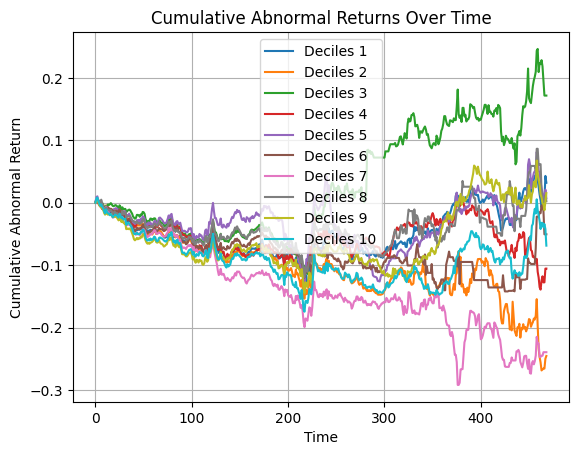

In [24]:
#cumulative graph for the entire set
outputs = torch.cat(all_predictions, dim=0)
all_labels = np.expand_dims(data['data'][:, :, 0], axis=2) #all labels [time, funds]
for i in range (1, 11):
    exec(f'timestep_return_{i} = []') 
timesteps = 469
for i in range (1, timesteps):
    #sort funds based on model prediction
    time = timesteps - i #the current timestep
    fund_data = sort_fund(outputs, timestep=time)
    for i in range (1, 11):
        decile_ind = select_decile(fund_data, i)
        decile = torch.tensor(all_labels)[time, decile_ind, :] #[funds, 1]
        #print('decile shape',decile.shape)
        #print("decile", decile)
        return_month = equal_weight(decile) #the weighted return for the month
        exec(f'timestep_return_{i}.append(return_month)')
all_timestep_return = []
labels = []
for i in range (1, 11):
    exec(f'all_timestep_return.append(timestep_return_{i})')
    labels.append(f'Deciles {i}')
plot_returns(all_timestep_return, labels, cumulative=True)

In [25]:
#np.savetxt("labels.txt", data['data'][250:, :, 0])

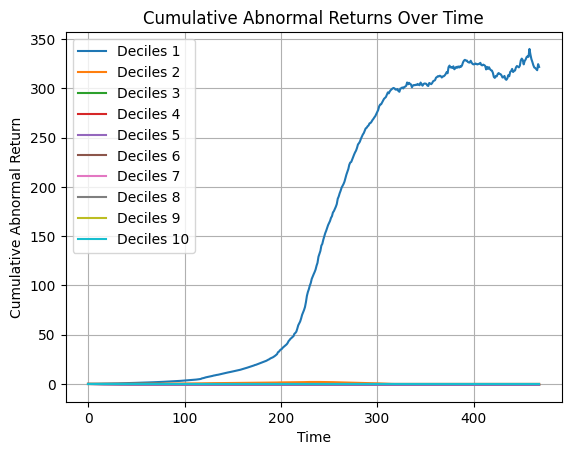

In [26]:
#graph the actual cumulative return 
#take the actual rank from the labels and graph 
all_labels = np.expand_dims(data['data'][:, :, 0], axis=2) #all labels
for i in range (1, 11):
    exec(f'timestep_return_{i} = []') 
for i in range (1, 469):
    #sort funds based on model prediction
    time = 469 - i #the current timestep
    fund_data = sort_fund(all_labels, timestep=time)
    fund_data.to_csv('funddata.csv')
    for i in range (1, 11):
        decile_ind = select_decile(fund_data, i)
        decile = torch.tensor(all_labels)[time, decile_ind, :] #[funds, 1]
        #print('decile shape',decile.shape)
        #print("decile", decile)
        return_month = equal_weight(decile) #the weighted return for the month
        exec(f'timestep_return_{i}.append(return_month)')
all_timestep_return = []
labels = []
for i in range (1, 11):
    exec(f'all_timestep_return.append(timestep_return_{i})')
    labels.append(f'Deciles {i}')
plot_returns(all_timestep_return, labels, cumulative=True)

In [27]:
#torch.save(model, 'trainedModels/curr')

In [28]:
'''sns.histplot(preds, bins=30, kde=True, color='blue')
plt.title('Distribution of predictions')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()
print("mean:", statistics.mean(preds))
print("median:", statistics.median(preds))
print("std:", statistics.stdev(preds))'''

'sns.histplot(preds, bins=30, kde=True, color=\'blue\')\nplt.title(\'Distribution of predictions\')\nplt.xlabel(\'Values\')\nplt.ylabel(\'Frequency\')\nplt.show()\nprint("mean:", statistics.mean(preds))\nprint("median:", statistics.median(preds))\nprint("std:", statistics.stdev(preds))'

In [29]:
def r2_loss(output, target, target_mean='infer'):
    if target_mean == "infer":
        target_mean = np.mean(target)
    ss_tot = np.sum((target - target_mean) ** 2)
    ss_res = np.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [30]:
#calculate R2 loss
outputs = torch.cat(all_predictions, dim=0).numpy()
all_labels = np.expand_dims(data['data'][:, :, 0], axis=2)
#mask off all missing values 
mask = (all_labels > -1)&(all_labels<1)
print(mask.shape)
outputs = outputs[mask]
all_labels = all_labels[mask]
print(outputs.shape, all_labels.shape)
outputs_flattend= outputs.flatten()
all_labels_flattened = all_labels.flatten()
R2 = r2_loss(outputs_flattend, all_labels_flattened, 0)
R2

(469, 3271, 1)
(407157,) (407157,)


-0.057090645765838444